In [1]:
rm(list = ls())
library(LalRUtils)
libreq(data.table, tidyverse, anytime, patchwork, plotly, lubridate, zoo)
theme_set(lal_plot_theme())
options(repr.plot.width = 15, repr.plot.height=12)

     wants        loaded
[1,] "data.table" TRUE  
[2,] "tidyverse"  TRUE  
[3,] "anytime"    TRUE  
[4,] "patchwork"  TRUE  
[5,] "plotly"     TRUE  
[6,] "lubridate"  TRUE  
[7,] "zoo"        TRUE  


# NYT county level time series 
https://github.com/nytimes/covid-19-data

In [2]:
#%% check timestamp at https://github.com/nytimes/covid-19-data
df = fread("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv")
df[, d := anydate(date)]
df %>% glimpse

Rows: 1,582,677
Columns: 7
$ date   <date> 2020-01-21, 2020-01-22, 2020-01-23, 2020-01-24, 2020-01-24, 20…
$ county <chr> "Snohomish", "Snohomish", "Snohomish", "Cook", "Snohomish", "Or…
$ state  <chr> "Washington", "Washington", "Washington", "Illinois", "Washingt…
$ fips   <int> 53061, 53061, 53061, 17031, 53061, 6059, 17031, 53061, 4013, 60…
$ cases  <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ deaths <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ d      <date> 2020-01-21, 2020-01-22, 2020-01-23, 2020-01-24, 2020-01-24, 20…


In [3]:
setorder(df, state, county, date)
df[,  `:=`(
  cfr = deaths/cases,
  new_cases  = cases - shift(cases),
  new_deaths = deaths - shift(deaths)
), by = .(state, county)]
# clean up
df[ ,`:=`(new_deaths = ifelse(new_deaths < 0, 0, new_deaths),
          new_cases  = ifelse(new_cases < 0, 0, new_cases)
              )]
df = df[d >= "2020-03-01"]
rawvars = c("cases", "deaths", "new_cases", "new_deaths")

In [4]:
df[order(-date, -cases)][1:20]
fwrite(df, 'data/nyt_county_level.csv.gz')

date,county,state,fips,cases,deaths,d,cfr,new_cases,new_deaths
<date>,<chr>,<chr>,<int>,<int>,<int>,<date>,<dbl>,<dbl>,<dbl>
2021-08-03,Los Angeles,California,6037,1308666,24705,2021-08-03,0.018878,2266,5
2021-08-03,New York City,New York,NA,979815,33557,2021-08-03,0.034248,1574,12
2021-08-03,Maricopa,Arizona,4013,586764,10480,2021-08-03,0.017861,1267,18
2021-08-03,Cook,Illinois,17031,566466,11131,2021-08-03,0.019650,686,4
2021-08-03,Miami-Dade,Florida,12086,542481,6472,2021-08-03,0.011930,0,0
2021-08-03,Harris,Texas,48201,427349,6729,2021-08-03,0.015746,1487,3
2021-08-03,Riverside,California,6065,318225,4667,2021-08-03,0.014666,500,0
2021-08-03,Dallas,Texas,48113,317707,4180,2021-08-03,0.013157,870,5
2021-08-03,San Diego,California,6073,315856,3798,2021-08-03,0.012024,1019,0


In [5]:
df[, nunique(fips)]
df[, .SD[1], by = county][is.na(fips)]

[1] 3219

county,date,state,fips,cases,deaths,d,cfr,new_cases,new_deaths
<chr>,<date>,<chr>,<int>,<int>,<int>,<date>,<dbl>,<dbl>,<dbl>
Unknown,2020-04-02,Alaska,NA,1,0,2020-04-02,0,NA,NA
Joplin,2020-06-25,Missouri,NA,103,0,2020-06-25,0,NA,NA
Kansas City,2020-03-20,Missouri,NA,12,0,2020-03-20,0,NA,NA
New York City,2020-03-01,New York,NA,1,0,2020-03-01,0,NA,NA


### Rolling Mean Function

In [6]:
rollmeaneR = function(df, 
                      smoothvars = rawvars,
                      grouping = c("state", "county"),
                      sm_k = 5){
    f = copy(df)
    setorderv(f, cols = c(grouping, 'd'))
    f[, paste0("rm", "_", smoothvars) := lapply(.SD, rollmean, k = sm_k, fill = NA, na.pad = T), 
       by = grouping, .SDcols = smoothvars]
    return(f)
}

# Nationwide 

In [9]:
options(warnings = -1)

In [7]:
npan = df[, lapply(.SD, sum, na.rm = T), by = .(d), .SDcols = rawvars]
npan[, gr := 1]
npan[, cfr := deaths/cases]
npan = rollmeaneR(npan, c(rawvars, 'cfr'), grouping = "gr")
npan[, day := weekdays(d)]
npan[, weekend := ifelse(day %in% c("Saturday", "Sunday"), 1, 0)]
npan[order(-d)][1:5]

d,cases,deaths,new_cases,new_deaths,gr,cfr,rm_cases,rm_deaths,rm_new_cases,rm_new_deaths,rm_cfr,day,weekend
<date>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2021-08-03,35325243,614104,150724,697,1,0.01738,NA,NA,NA,NA,NA,Tuesday,0
2021-08-02,35175455,613436,135829,467,1,0.01744,NA,NA,NA,NA,NA,Monday,0
2021-08-01,35039644,612982,23142,66,1,0.01749,35108732,613243,106898,412.8,0.01747,Sunday,1
2021-07-31,35016505,612919,30144,146,1,0.01750,35016511,612843,96361,355.6,0.01750,Saturday,1
2021-07-30,34986813,612775,194651,688,1,0.01751,34934654,612498,87847,367.6,0.01753,Friday,0


`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”


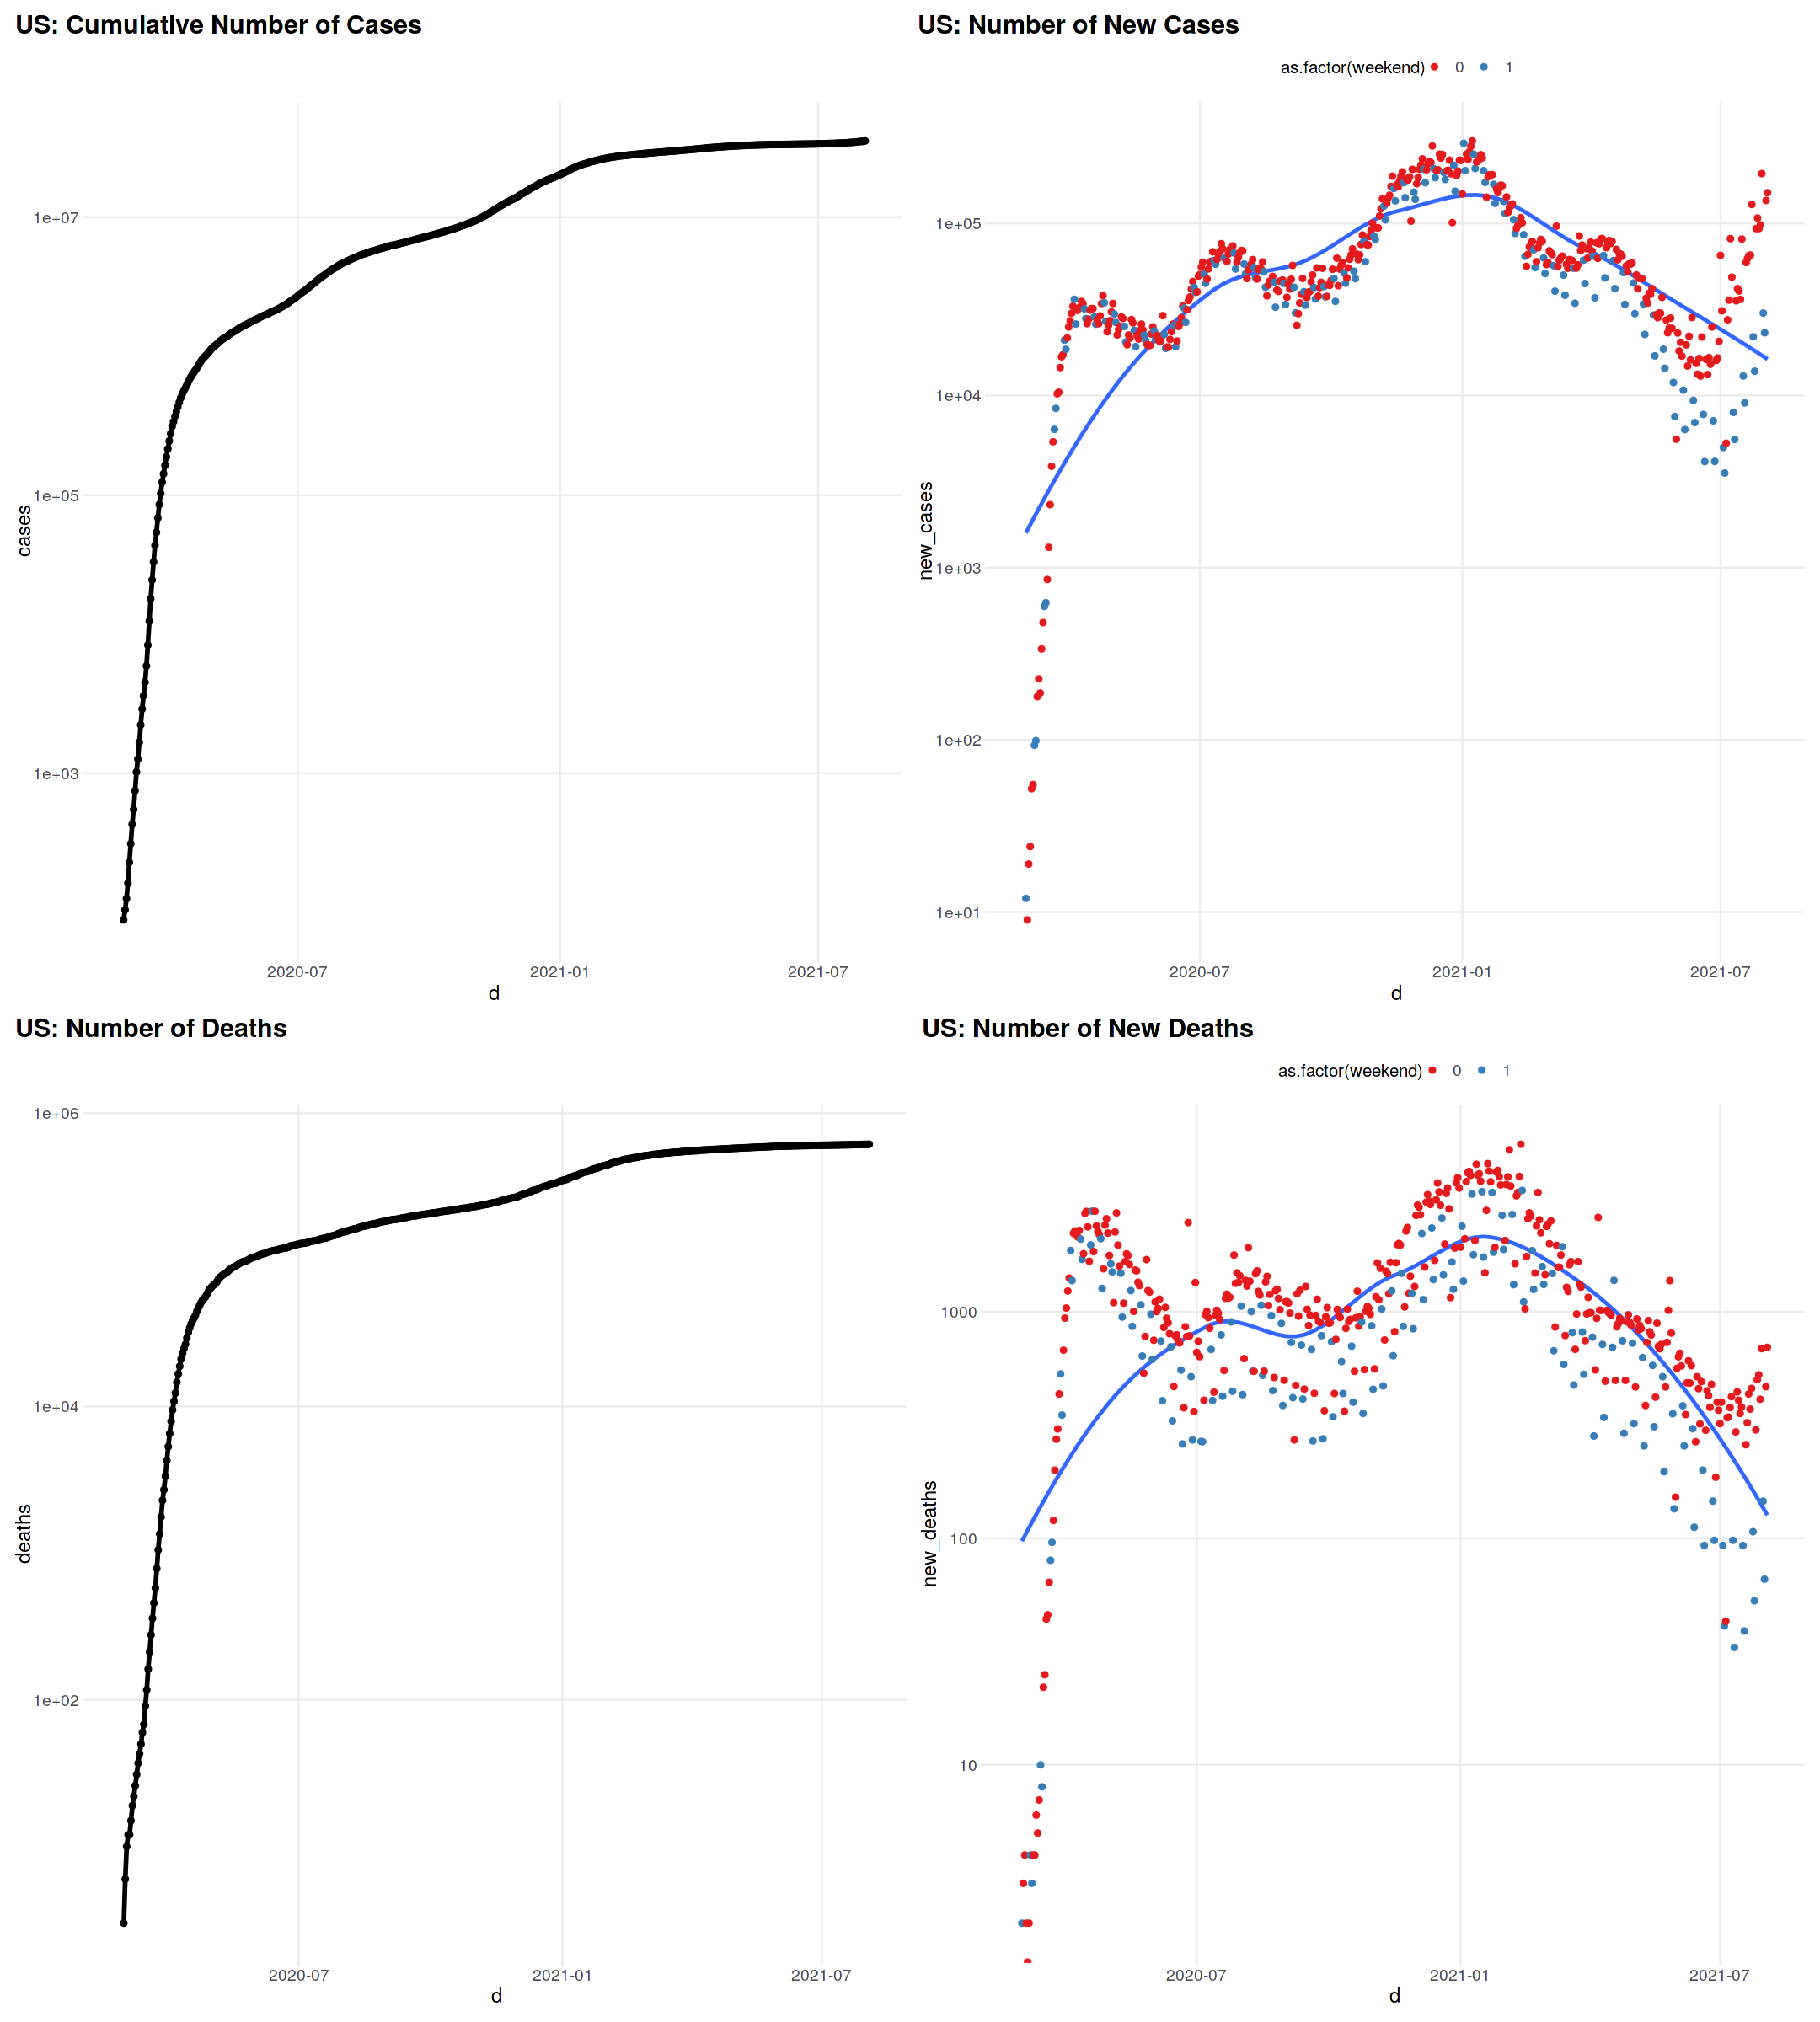

In [10]:
options(repr.plot.width = 20, repr.plot.height=16)
p1 = ggplot(npan, aes(x = d, y = cases)) +
  geom_line(size = 1.2) + geom_point()+ 
  scale_y_log10() +
  ggtitle("US: Cumulative Number of Cases")

p11 = ggplot(npan, aes(x = d, y = new_cases)) +
#   geom_line(aes(y = rm_new_cases)) +
    geom_smooth(se = F) +
    geom_point(aes( colour = as.factor(weekend))) +
    scale_y_log10() +
    scale_colour_brewer(palette = "Set1") + 
    ggtitle("US: Number of New Cases")

p2 = ggplot(npan, aes(x = d, y = deaths)) +
  geom_line(size = 1.2) + geom_point() +
  scale_y_log10() +
  ggtitle("US: Number of Deaths")

p22 = ggplot(npan, aes(x = d, y = new_deaths)) +
#   geom_line(aes(y = rm_new_deaths)) +
    geom_smooth(se = F) +
    geom_point(aes(colour = as.factor(weekend))) +
    scale_y_log10() + 
    scale_colour_brewer(palette = "Set1") + 
    ggtitle("US: Number of New Deaths")

options(repr.plot.width = 18, repr.plot.height=20)
(p1 | p11) /( p2 | p22)

In [9]:
options(repr.plot.width = 10, repr.plot.height=8)
nat_cfr = ggplot(npan[d>= "2020-03-15"], aes(x = d, y = cfr)) +
  geom_line(aes(y = rm_cfr)) + geom_point()+ 
  ggtitle("US: CFR")

## State Panel 

In [11]:
stpan = df[, lapply(.SD, sum, na.rm = T), by = .(state, d), .SDcols = rawvars]
(t10 = stpan[d == max(d)][order(-cases)][1:10])
stpan[, cfr := deaths/cases]
stpan = rollmeaneR(stpan, c(rawvars, 'cfr'), grouping = "state")

state,d,cases,deaths,new_cases,new_deaths
<chr>,<date>,<int>,<int>,<dbl>,<dbl>
California,2021-08-03,4073875,64533,7640,16
Texas,2021-08-03,3162305,53514,20029,64
Florida,2021-08-03,2641696,39179,50997,100
New York,2021-08-03,2156305,53294,3062,13
Illinois,2021-08-03,1431494,25940,2571,11
Pennsylvania,2021-08-03,1233461,27868,1223,11
Georgia,2021-08-03,1168207,21022,8817,24
Ohio,2021-08-03,1132798,20530,1769,38
North Carolina,2021-08-03,1060143,13695,2939,14


Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 40 row(s) containing missing values (geom_path).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 40 row(s) containing missing values (geom_path).”


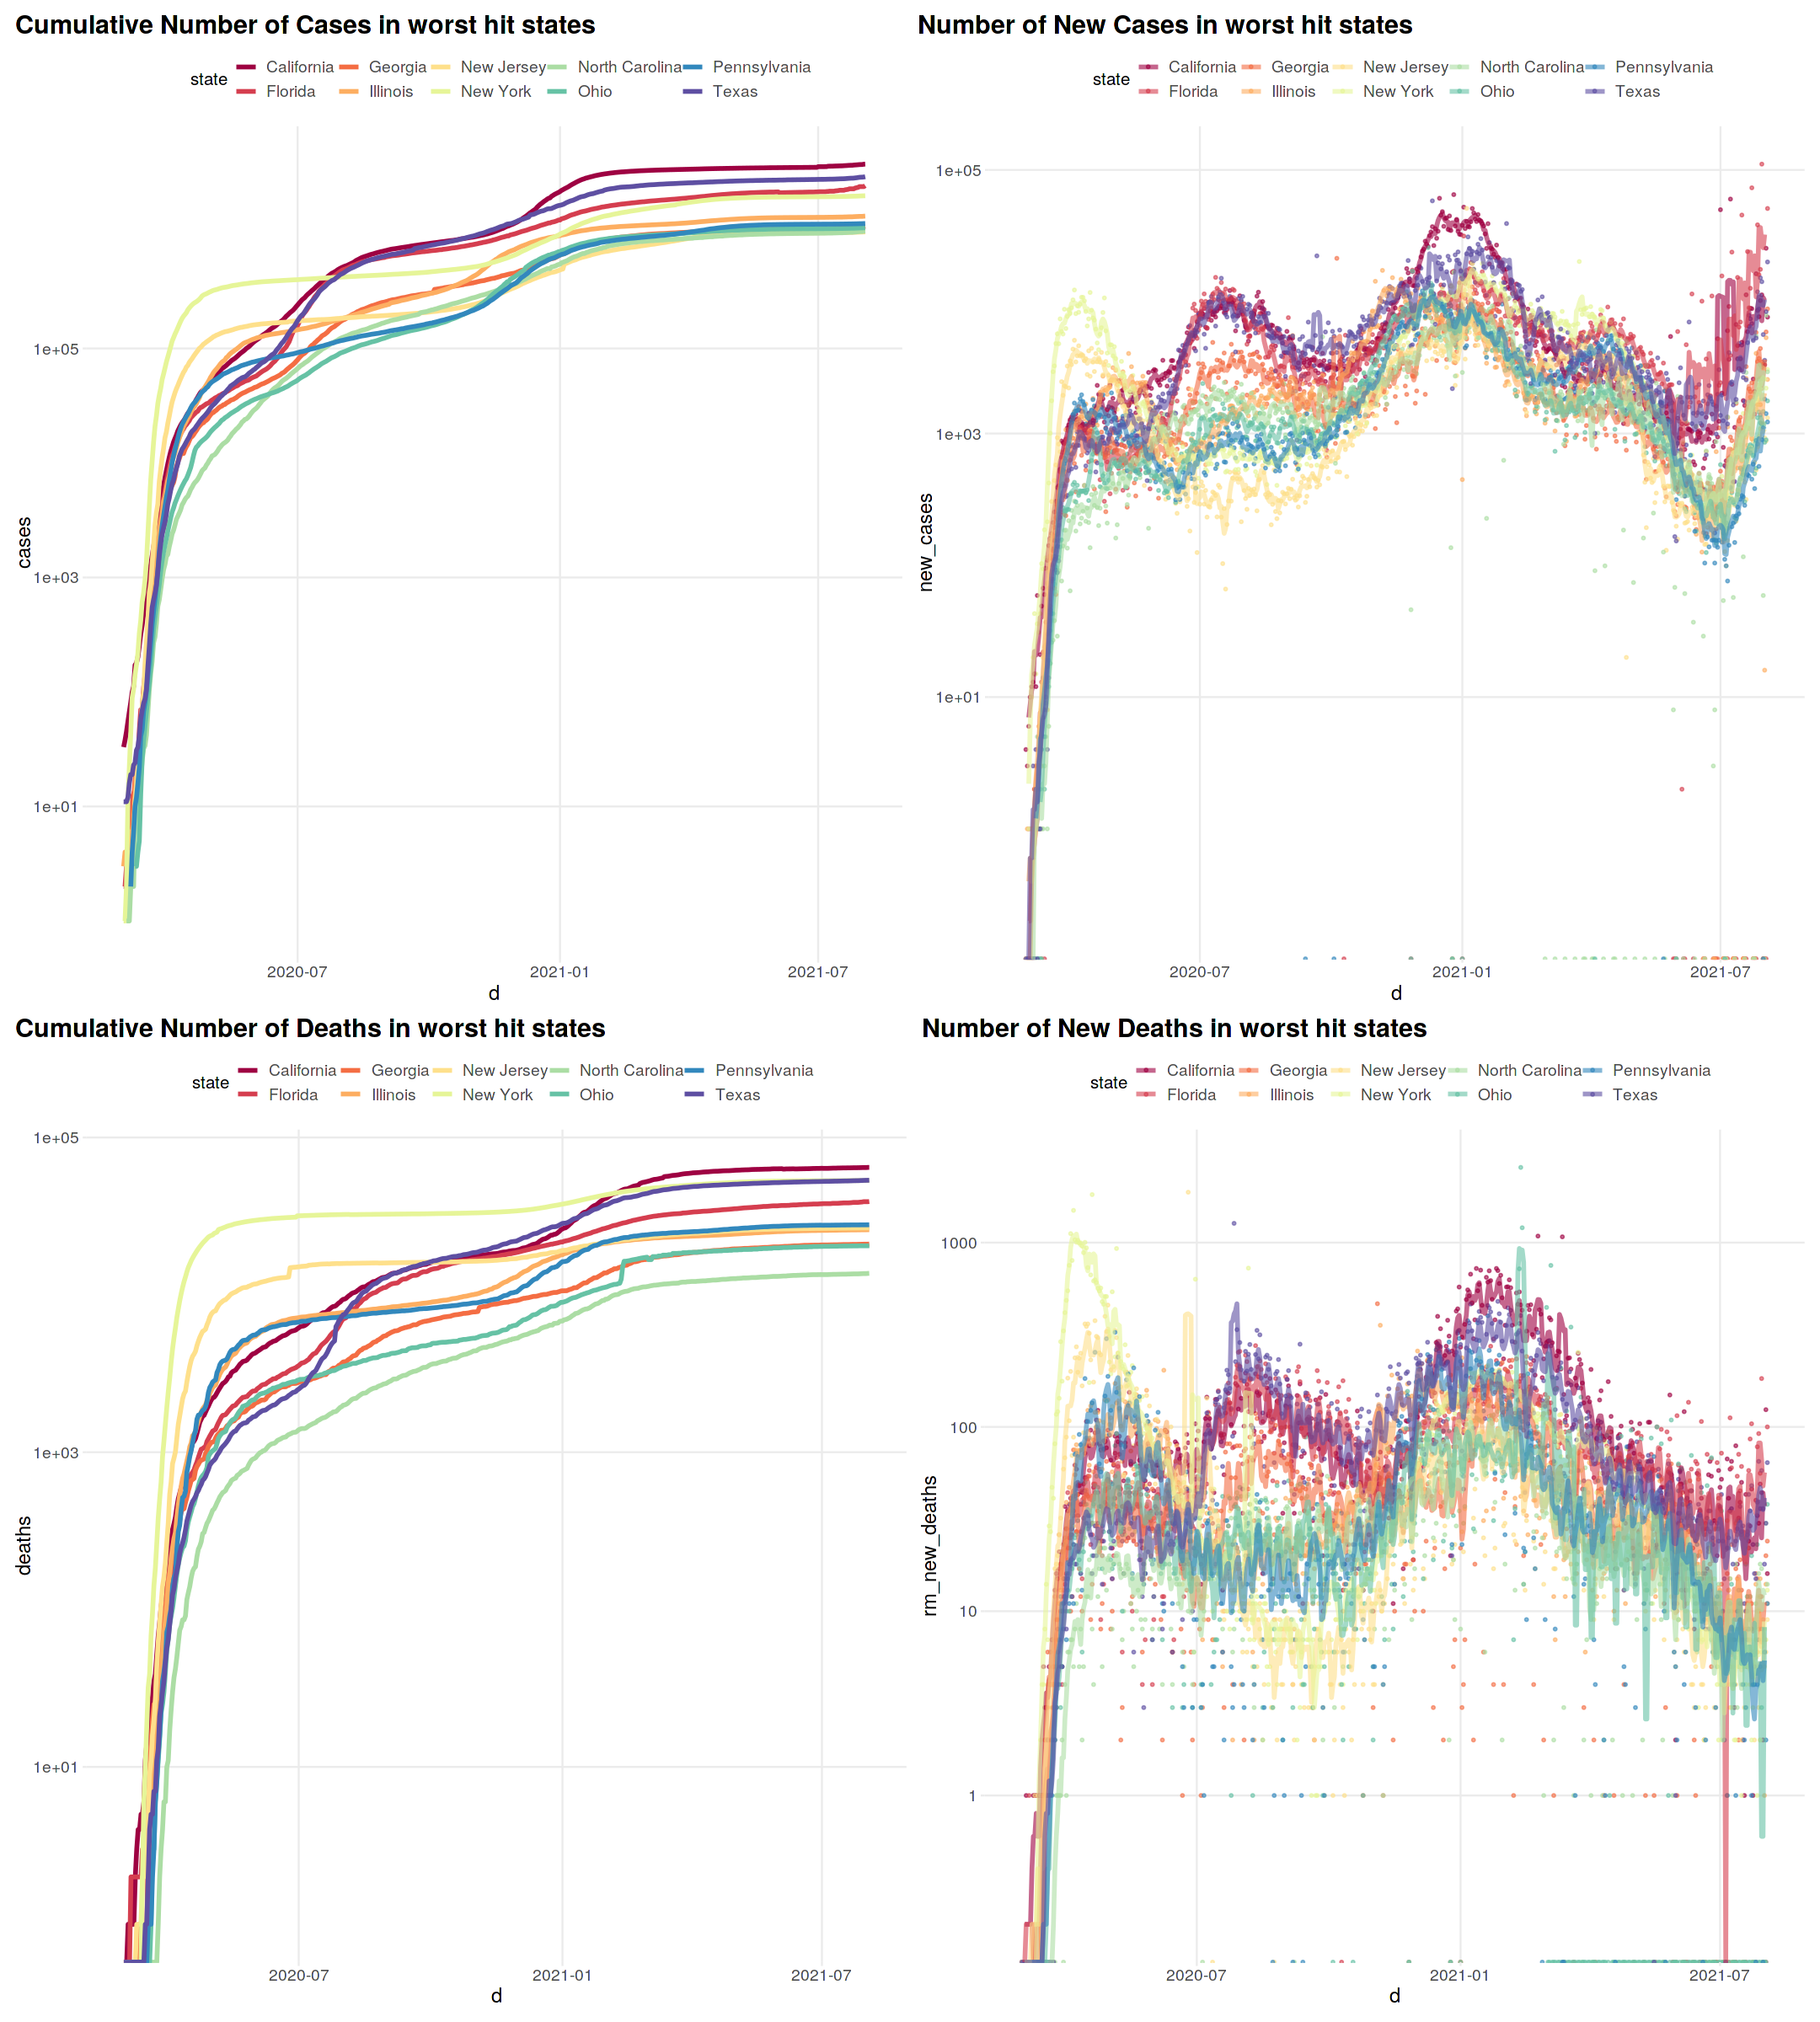

In [13]:
options(repr.plot.width = 20, repr.plot.height=16)
p1 = ggplot(stpan[state %in% t10$state], aes(x = d, y = cases, group = state, colour = state)) +
  geom_line(size = 1.2) +
  scale_y_log10() +
  scale_colour_brewer(palette = "Spectral") + 
  ggtitle("Cumulative Number of Cases in worst hit states")

p11 = ggplot(stpan[state %in% t10$state], aes(x = d, group = state, colour = state)) +
  geom_point(aes(y = new_cases), size = 0.6, alpha = 0.6) +
  geom_line(aes(y = rm_new_cases), size = 1.2, alpha = 0.6) +
  scale_y_log10() +
  scale_colour_brewer(palette = "Spectral") + 
  ggtitle("Number of New Cases in worst hit states")

p2 = ggplot(stpan[state %in% t10$state], aes(x = d, y = deaths, group = state, colour = state)) +
  geom_line(size = 1.2) +
  scale_y_log10() +
  scale_colour_brewer(palette = "Spectral") + 
  ggtitle("Cumulative Number of Deaths in worst hit states")

p22 = ggplot(stpan[state %in% t10$state], aes(x = d, y = rm_new_deaths, group = state, colour = state)) +
  geom_point(aes(y = new_deaths), size = 0.6, alpha = 0.6) +
  geom_line(aes(y = rm_new_deaths), size = 1.2, alpha = 0.6) +
  scale_y_log10() + 
  scale_colour_brewer(palette = "Spectral") + 
  ggtitle("Number of New Deaths in worst hit states")

options(repr.plot.width = 18, repr.plot.height=20)
(p1 | p11) /( p2 | p22)

+ TBD - merge in small area poverty estimates 
https://www2.census.gov/programs-surveys/saipe/datasets/2018/2018-state-and-county/est18all.xls
+ Census population data codebook
https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2010-2019/co-est2019-alldata.pdf

In [ ]:
county_tables = fread("https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.csv")
county_tables %>% glimpse
county_tables[, fips := as.numeric(sprintf("%02d%03d", STATE, COUNTY))]
fwrite(county_tables, "data/county_popest.csv")

In [ ]:
county_level = county_tables[SUMLEV == 50]

In [ ]:
df_w_popn = merge(df[!is.na(fips)], county_level[!is.na(fips), .(fips, CENSUS2010POP)], by = 'fips')
df_w_popn %>% glimpse

## CA: Subregions

In [14]:
bay_counties = c(
  "San Francisco", "San Mateo", "Santa Clara",
  "Alameda", "Contra Costa", "Marin"
)

socal = c("Los Angeles", "Orange", "Ventura", "San Bernadino", "Riverside",
          "Imperial", "Kern", "San Diego", "Santa Barbara", "San Luis Obispo")

ca_all = df[state == "California"]
ca_all[, metro := case_when(
    county %in% bay_counties ~ "Bay",
    county %in% socal        ~ "SoCal",
    TRUE                     ~ "Elsewhere")]
vars = c("cases", "deaths", "new_cases", "new_deaths")
ca_div = ca_all[, lapply(.SD, sum, na.rm = T), 
   by = .(metro, d), .SDcols = vars]

In [15]:
ca_div = rollmeaneR(ca_div, smoothvars = vars, grouping = 'metro')

In [16]:
kvs = c("cases", "deaths", "new_cases", "new_deaths", 'd')
cur = ca_div[order(-d), .SD[1], by = metro, .SDcols = kvs]
cur[, lapply(.SD, sum, na.rm = T), .SDcols = vars]

cases,deaths,new_cases,new_deaths
<int>,<int>,<dbl>,<dbl>
3927543,64296,10905,33


Warning message:
“Removed 12 row(s) containing missing values (geom_path).”
Warning message:
“Removed 12 row(s) containing missing values (geom_path).”


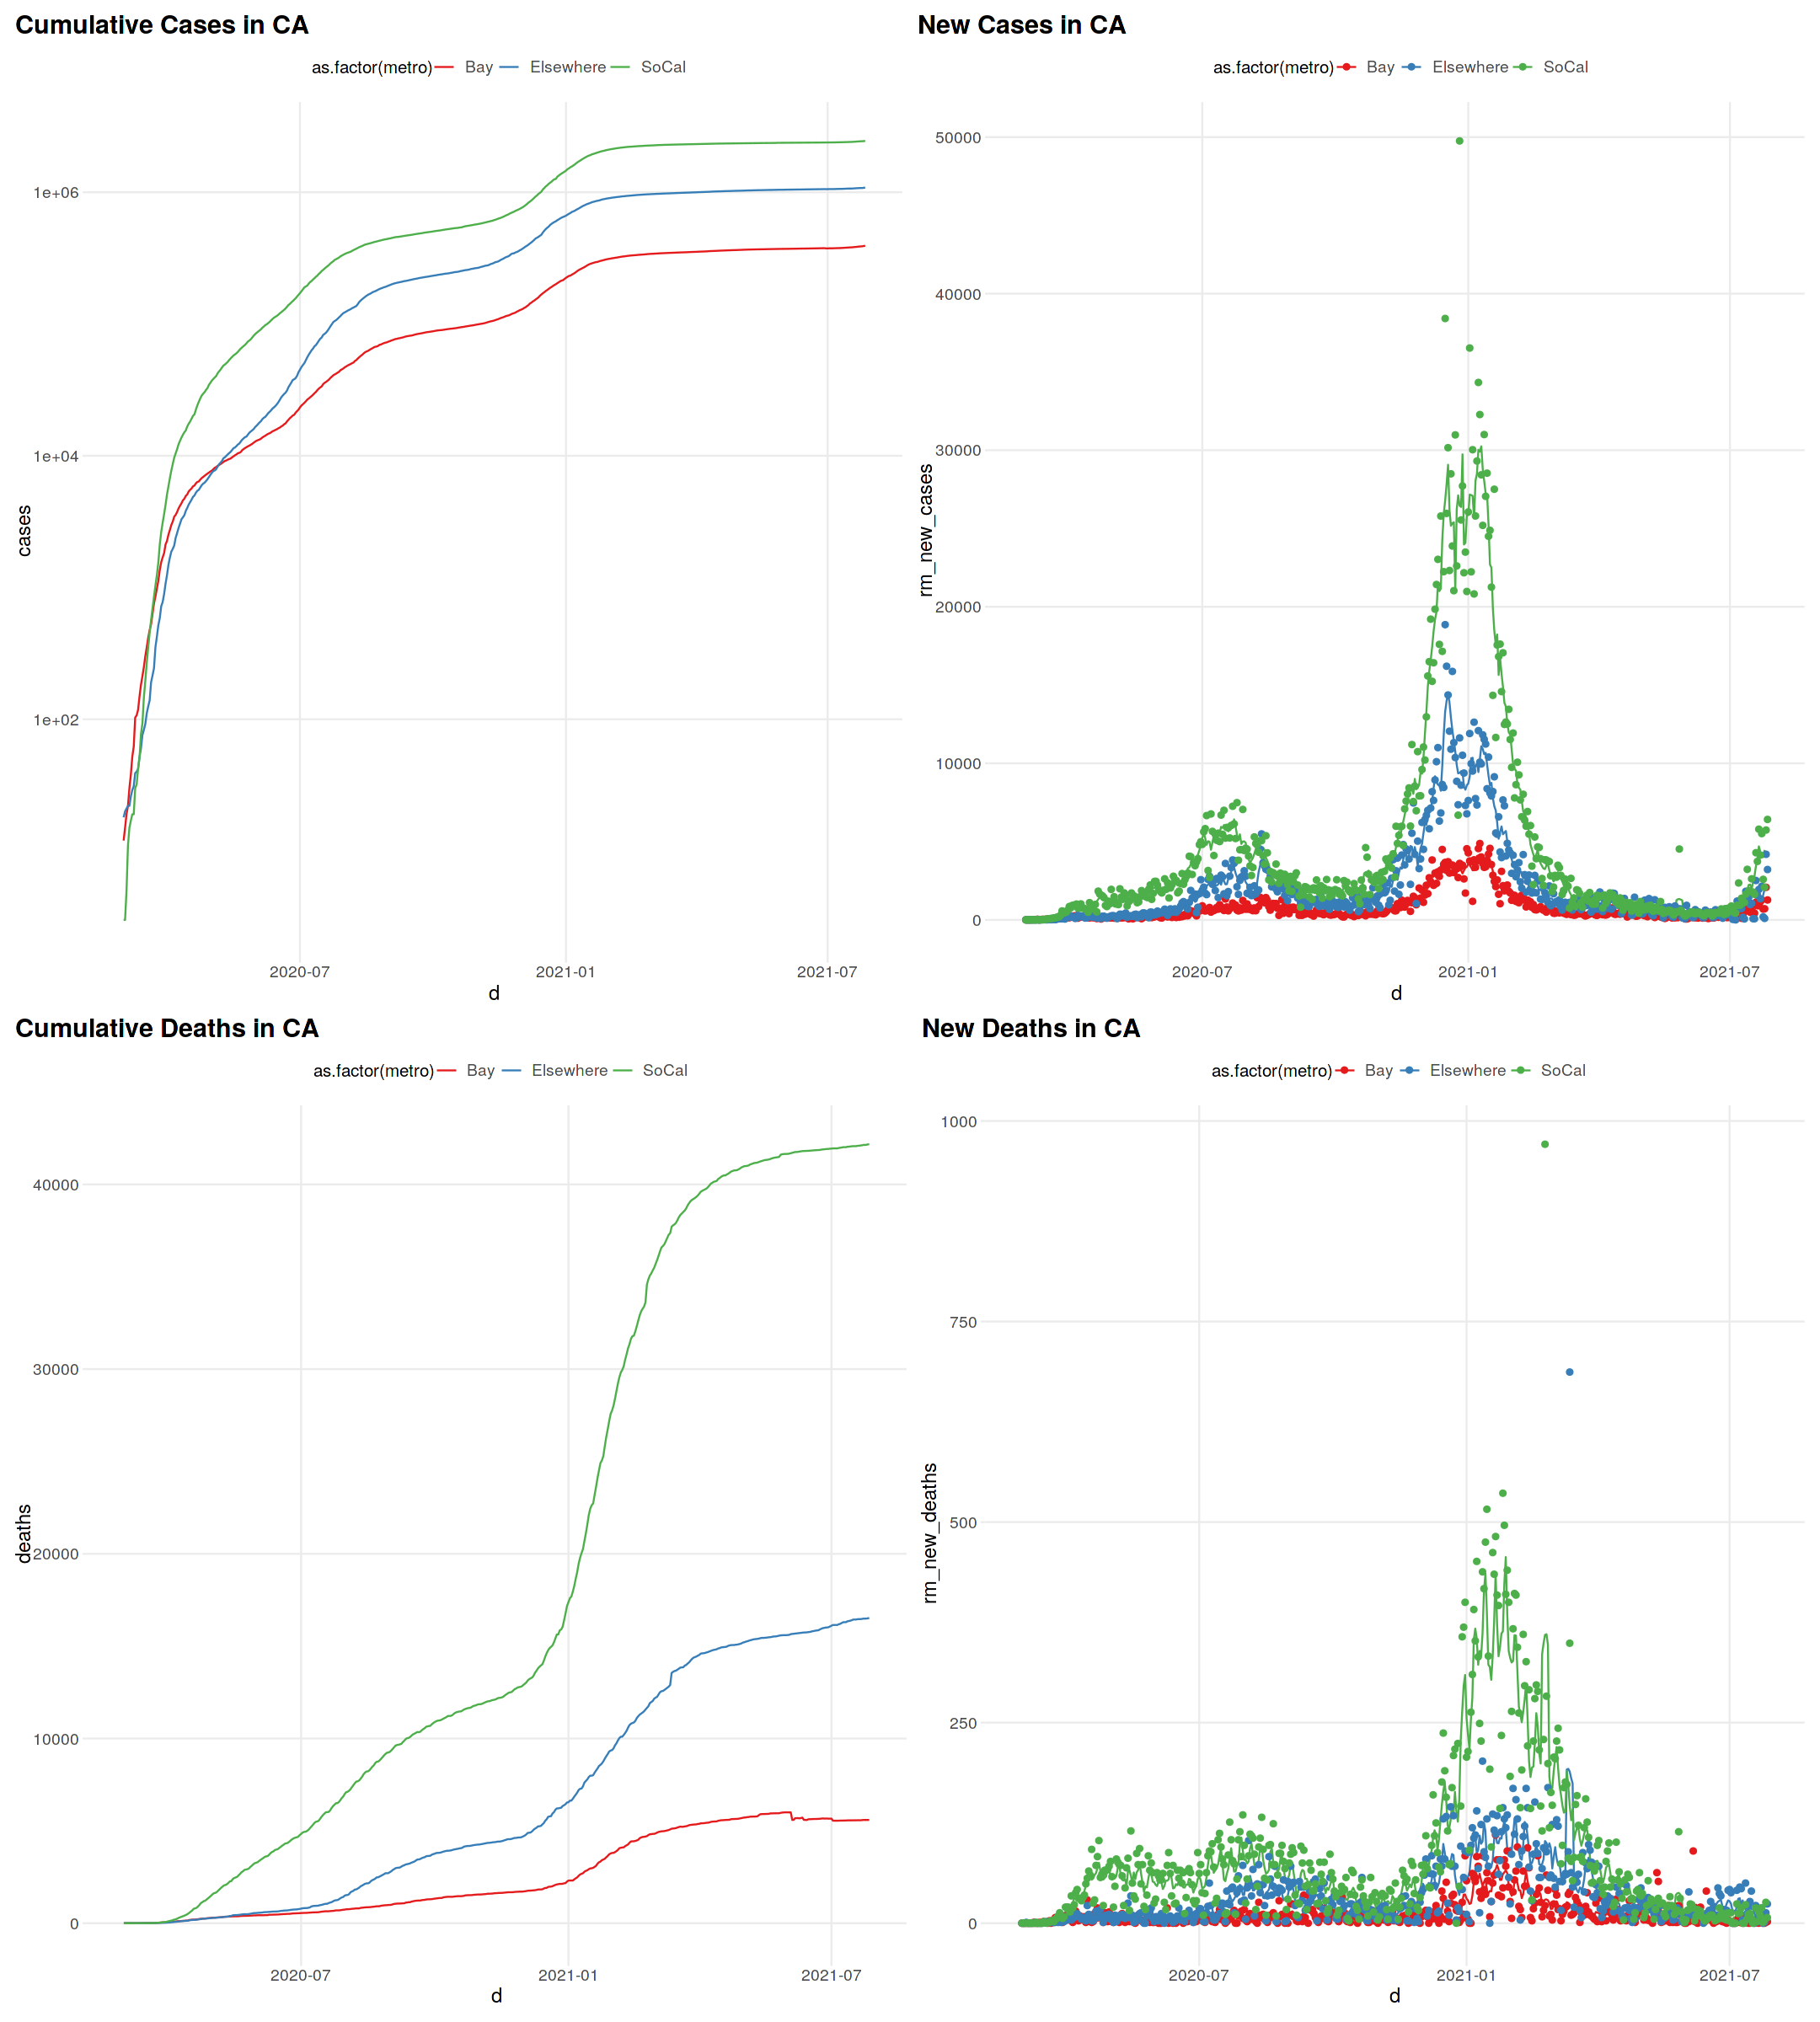

In [17]:
p1 = ggplot(ca_div, aes(x = d, y = cases, group = as.factor(metro), colour = as.factor(metro))) +
    geom_line() + scale_y_log10()+
  scale_colour_brewer(palette = 'Set1') +
    ggtitle("Cumulative Cases in CA")
p2 = ggplot(ca_div, aes(x = d,  group = as.factor(metro), colour = as.factor(metro))) +
  geom_line(aes(y = rm_new_cases)) +
  geom_point(aes(y = new_cases)) +
  scale_colour_brewer(palette = 'Set1') +
    ggtitle("New Cases in CA")
p3 = ggplot(ca_div, aes(x = d, y = deaths, group = as.factor(metro), colour = as.factor(metro))) +
  geom_line() +
  scale_colour_brewer(palette = 'Set1') +
    ggtitle("Cumulative Deaths in CA")

p4 = ggplot(ca_div, aes(x = d, y = rm_new_deaths, group = as.factor(metro), colour = as.factor(metro))) +
  geom_line(aes(y = rm_new_deaths)) +
  geom_point(aes(y = new_deaths)) +
  scale_colour_brewer(palette = 'Set1') +
    ggtitle("New Deaths in CA")

options(repr.plot.width = 18, repr.plot.height=20)
(p1 | p2 ) / (p3 | p4)

## Counties within the Bay Area

In [18]:
bayrea_mar = rollmeaneR(df[county %in% bay_counties & state == "California" & d>= "2020-03-01"])
bayrea_mar[, cfr := deaths/cases]
bayrea_mar[d == max(d)]

date,county,state,fips,cases,deaths,d,cfr,new_cases,new_deaths,rm_cases,rm_deaths,rm_new_cases,rm_new_deaths
<date>,<chr>,<chr>,<int>,<int>,<int>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2021-07-27,Alameda,California,6001,95264,1274,2021-07-27,0.01337,447,2,NA,NA,NA,NA
2021-07-27,Contra Costa,California,6013,75580,830,2021-07-27,0.01098,368,0,NA,NA,NA,NA
2021-07-27,Marin,California,6041,14579,239,2021-07-27,0.01639,21,0,NA,NA,NA,NA
2021-07-27,San Francisco,California,6075,39803,561,2021-07-27,0.01409,137,0,NA,NA,NA,NA
2021-07-27,San Mateo,California,6081,44297,588,2021-07-27,0.01327,108,0,NA,NA,NA,NA
2021-07-27,Santa Clara,California,6085,122630,2100,2021-07-27,0.01712,191,0,NA,NA,NA,NA


### Cases

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 3 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”


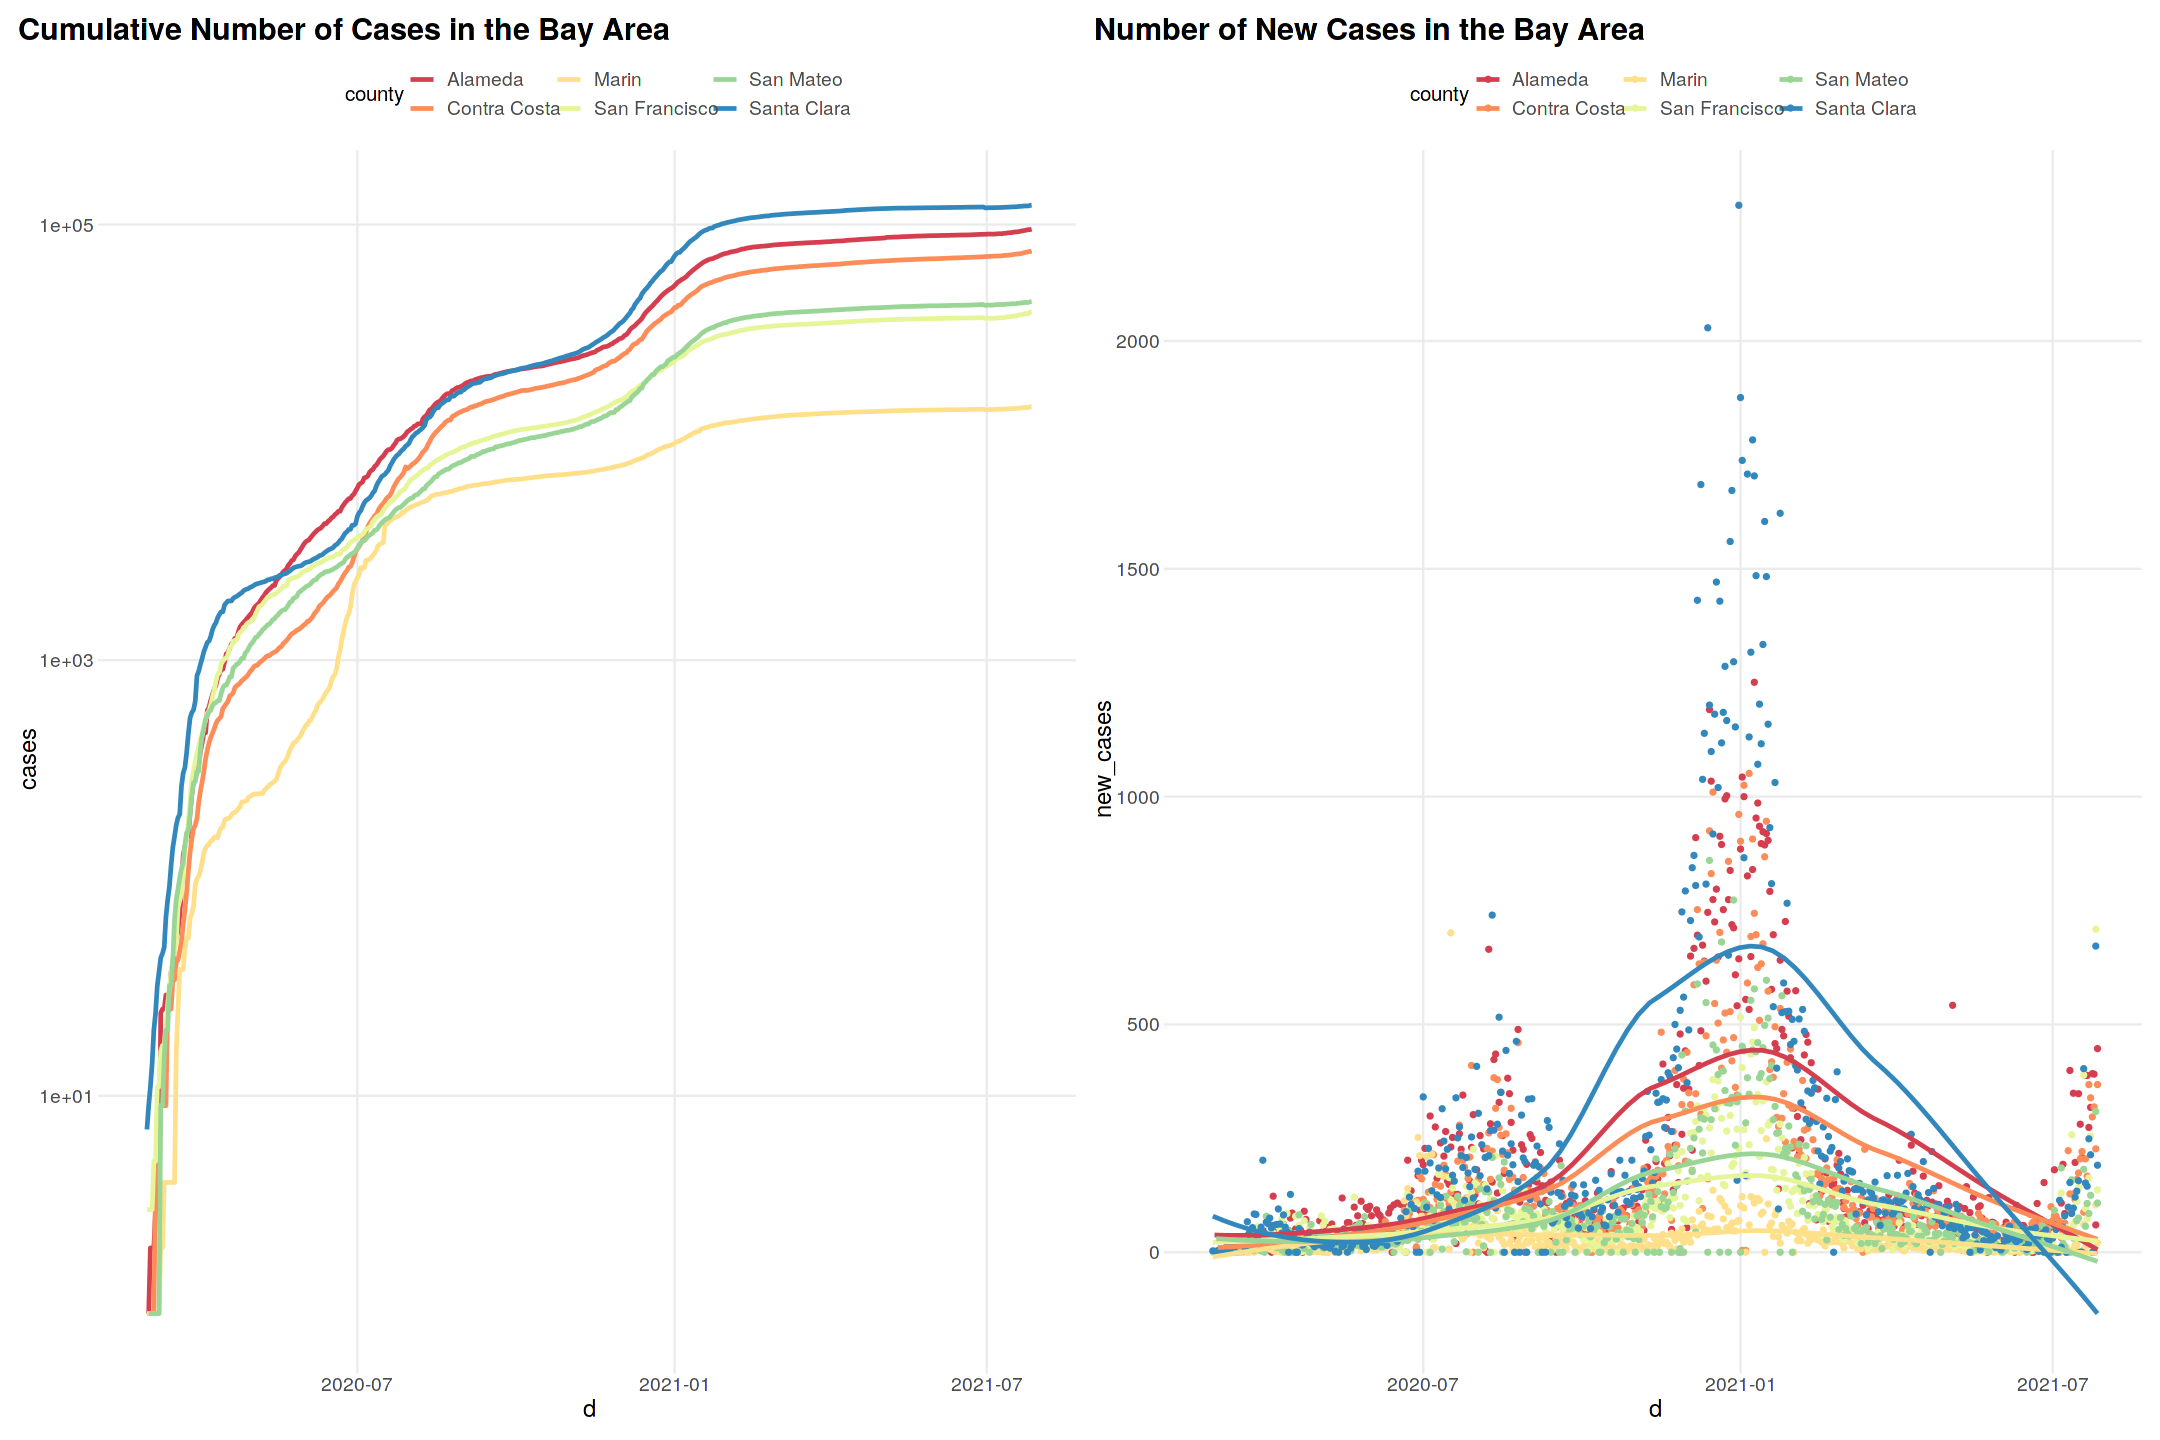

In [19]:
p1 = ggplot(bayrea_mar, aes(x = d, y = cases, group = county, colour = county)) +
  geom_line(size = 1) +
  scale_y_log10() +
  scale_colour_brewer(palette = 'Spectral') +
  ggtitle("Cumulative Number of Cases in the Bay Area")

p2 = ggplot(bayrea_mar, aes(x = d, y = new_cases, group = county, colour = county)) +
  geom_point(size = 1) +
    geom_smooth(se = F) +
    scale_colour_brewer(palette = 'Spectral') +
    ggtitle("Number of New Cases in the Bay Area")
options(repr.plot.width = 18, repr.plot.height=12)
(p1 | p2)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 3 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”


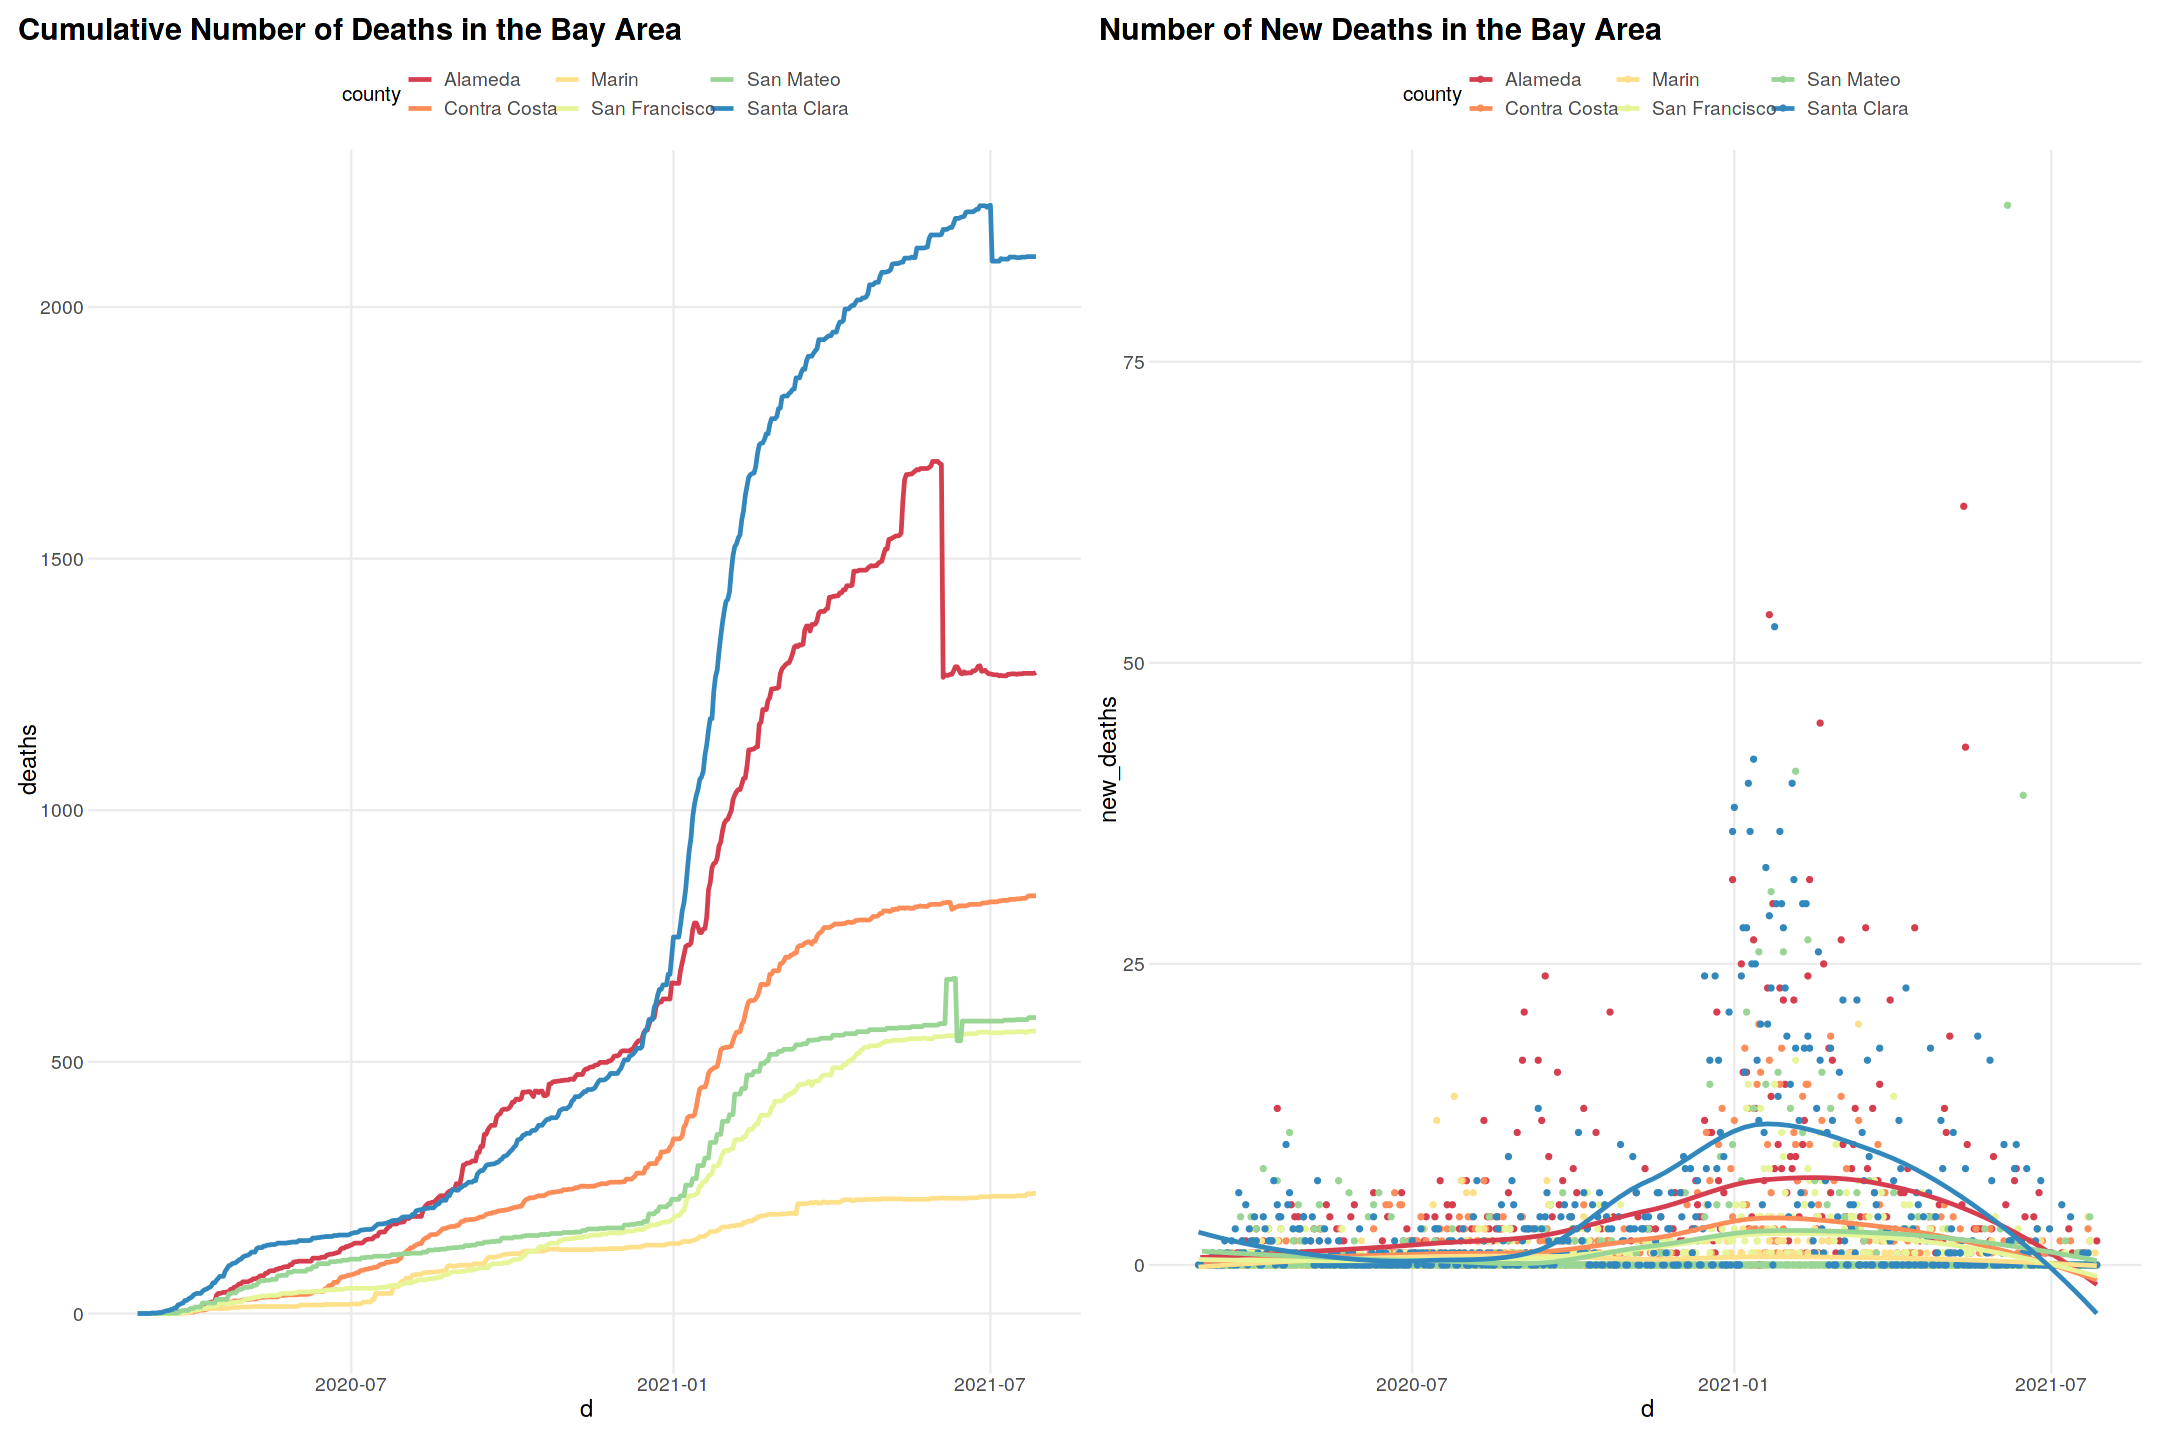

In [20]:
p1 = ggplot(bayrea_mar, aes(x = d, y = deaths, group = county, colour = county)) +
  geom_line(size = 1) +
  scale_colour_brewer(palette = 'Spectral') +
  ggtitle("Cumulative Number of Deaths in the Bay Area")
p2 = ggplot(bayrea_mar, aes(x = d, y = new_deaths, group = county, colour = county)) +
  geom_point(aes(y = new_deaths), size = 1) +
#   geom_line(size = 1) +
  geom_smooth(se = F) +
  scale_colour_brewer(palette = 'Spectral') +
  ggtitle("Number of New Deaths in the Bay Area")
(p1 | p2)